<a href="https://colab.research.google.com/github/SaM27my/EE58009_ML_WC_Assinments/blob/main/path_loss_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Path Loss Prediction with Supervised Learning
## EE 48009 & EE 58009 - Assignment 1

This notebook implements ray-traced wireless propagation data generation using Sionna and applies supervised learning to predict path loss.

**Key Concepts:**
- **Ray Tracing**: Computational technique to model electromagnetic wave propagation by tracing paths from transmitter to receiver
- **Path Loss**: Reduction in power density of an electromagnetic wave as it propagates through space
- **Supervised Learning**: Training models to predict path loss (target) from physical/environmental features (inputs)

**Bridge to Wireless Communications:**
- We use **regression models** (ML concept) for **channel propagation modeling** (wireless concept)
- Features like AoA/AoD, delay spread → inputs to **neural networks** or **random forests**
- Goal: Replace expensive ray tracing with fast ML inference for **network planning** and **resource allocation**

## Step 0: Installation and Imports

In [1]:
# Install Sionna (if not already installed)
!pip install sionna

import sionna
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Check Sionna version
print(f"Sionna version: {sionna.__version__}")
print(f"TensorFlow version: {tf.__version__}")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

Sionna version: 1.2.1
TensorFlow version: 2.19.0


## Step 1: Choose the Scenario

**Scene Selection Rationale:**
- We'll use the **Munich** scene (urban outdoor) or **Etoile** scene (urban intersection)
- These scenes are appropriate for 28 GHz mmWave study because:
  - Dense multipath environment with buildings causing reflections/diffractions
  - Realistic for 5G urban deployment scenarios
  - Sufficient complexity to demonstrate ML model learning

**Wireless Context:**
- 28 GHz is in the **mmWave band** (24-100 GHz)
- High path loss and blockage → need for accurate propagation models
- Critical for 5G NR FR2 (Frequency Range 2) network planning

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies


In [ ]:
# Load the simple street canyon scene
scene = load_scene(sionna.rt.scene.munich)

# Set carrier frequency to 28 GHz (mmWave)
scene.frequency = 28e9  # Hz

# Create camera for visualization
my_cam = Camera(position=[-100, 100, 200], look_at=[-15, 30, 28])

# Render the scene
scene.render(camera=my_cam, resolution=[650, 500], num_samples=128)

print(f"Scene loaded: Simple Street Canyon")
print(f"Carrier Frequency: {scene.frequency/1e9} GHz")

### Scene Choice: Simple Street Canyon

**Justification:**
- **Urban outdoor environment**: Representative of mmWave deployment scenarios in cities
- **Rich multipath**: Buildings create reflections and blockages, ideal for LoS/NLoS analysis
- **Realistic geometry**: Suitable for studying path loss variation over distance
- **28 GHz mmWave**: Chosen frequency is typical for 5G NR and experiences significant path loss and blockage effects

This scene allows us to generate diverse propagation conditions for training a robust path loss prediction model.

## Step 2: Define the Transmitter (TX)

We will:
1. Place a fixed transmitter (base station) at an appropriate location
2. Configure it with an MxM uniform planar array (UPA)
3. Make M parametric (will test M = 1, 4, 8)
4. Orient the antenna to cover the receiver area

In [ ]:
# First, let's identify a good TX location
# Based on the simple_street_canyon scene, we'll place TX on a rooftop

# TX position (x, y, z) - elevated position for base station
tx_position = np.array([33.24, 10.71, 24.59])  # From demo, rooftop location

# Visualize TX position
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot TX
ax.scatter(tx_position[0], tx_position[1], tx_position[2],
           color='red', s=200, marker='^', label='TX (Base Station)')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Transmitter Location')
ax.legend()
plt.grid(True)
plt.show()

print(f"TX Position: {tx_position}")
print(f"TX Height: {tx_position[2]} m (rooftop deployment)")

In [ ]:
# Define parametric M for antenna array size
M = 1  # Start with M=1 (single antenna), will test M=1, 4, 8 later

# Configure TX antenna array - MxM UPA
scene.tx_array = PlanarArray(
    num_rows=M,
    num_cols=M,
    vertical_spacing=0.5,    # in wavelengths
    horizontal_spacing=0.5,  # in wavelengths
    pattern="iso",           # isotropic pattern for simplicity
    polarization="V"         # vertical polarization
)

print(f"TX Array Configuration:")
print(f"  Array size: {M}x{M} = {M*M} elements")
print(f"  Pattern: isotropic")
print(f"  Polarization: Vertical")
print(f"  Element spacing: 0.5λ")

# Calculate wavelength at 28 GHz (convert to numpy float)
freq_hz = float(scene.frequency.numpy()) if hasattr(scene.frequency, 'numpy') else float(scene.frequency)
wavelength = 3e8 / freq_hz
print(f"\nWavelength at 28 GHz: {wavelength*1000:.2f} mm")
print(f"Element spacing: {0.5*wavelength*1000:.2f} mm")

TX Array Configuration:
  Array size: 1x1 = 1 elements
  Pattern: isotropic
  Polarization: Vertical
  Element spacing: 0.5λ

Wavelength at 28 GHz: 10.71 mm
Element spacing: 5.36 mm


/tmp/ipython-input-2788941331.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  freq_hz = float(scene.frequency.numpy()) if hasattr(scene.frequency, 'numpy') else float(scene.frequency)


In [ ]:
# Create transmitter object
tx = Transmitter(name="tx", position=tx_position)

# Add to scene
scene.add(tx)

# We'll set the orientation after defining RX area in next step
# For now, point it downward and towards the street
tx.look_at([0, 0, 1.5])  # Look at street level, center of scene

print(f"Transmitter '{tx.name}' added to scene")
print(f"Position: {tx.position}")

## Step 3: Define the Receiver (RX) Grid

We will:
1. Create a uniform 2D grid of receiver locations
2. Choose appropriate spacing based on scene size
3. Place receivers at street level (realistic user height ~1.5m)
4. Generate multiple RX points for a comprehensive dataset

In [ ]:
# For simple_street_canyon, let's define a reasonable coverage area
# Based on the scene, we'll create a grid in the street area

# Define grid boundaries (x, y coordinates)
x_min, x_max = -60, 40   # Along street length
y_min, y_max = -20, 30   # Across street width
z_rx = 1.5               # Receiver height (typical user device height)

# Grid spacing - using 5m for urban scene (as per assignment guidance)
grid_spacing = 5.0  # meters

print(f"RX Grid Configuration:")
print(f"  X range: [{x_min}, {x_max}] m")
print(f"  Y range: [{y_min}, {y_max}] m")
print(f"  Z height: {z_rx} m (street level)")
print(f"  Grid spacing: {grid_spacing} m")

In [ ]:
# Create uniform grid
x_coords = np.arange(x_min, x_max + grid_spacing, grid_spacing)
y_coords = np.arange(y_min, y_max + grid_spacing, grid_spacing)

# Create meshgrid
X_grid, Y_grid = np.meshgrid(x_coords, y_coords)

# Flatten to get list of points
rx_positions = np.column_stack([
    X_grid.flatten(),
    Y_grid.flatten(),
    np.full(X_grid.size, z_rx)  # All at same height
])

num_rx_points = rx_positions.shape[0]

print(f"\nGenerated {num_rx_points} RX points")
print(f"Grid dimensions: {len(x_coords)} x {len(y_coords)}")
print(f"\nFirst 5 RX positions:")
print(rx_positions[:5])

In [ ]:
# Visualize TX and all RX positions
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot RX grid points
ax.scatter(rx_positions[:, 0], rx_positions[:, 1], rx_positions[:, 2],
           c='blue', s=20, alpha=0.6, label=f'RX Grid ({num_rx_points} points)')

# Plot TX
ax.scatter(tx_position[0], tx_position[1], tx_position[2],
           c='red', s=300, marker='^', edgecolors='black', linewidths=2,
           label='TX (Base Station)')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('TX and RX Grid Layout')
ax.legend()
ax.view_init(elev=30, azim=45)
plt.grid(True)
plt.show()

# Also show top view
fig2, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(rx_positions[:, 0], rx_positions[:, 1],
            c='blue', s=30, alpha=0.6, label='RX points')
ax2.scatter(tx_position[0], tx_position[1],
            c='red', s=300, marker='^', edgecolors='black', linewidths=2,
            label='TX')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_title('Top View: TX and RX Grid')
ax2.legend()
ax2.grid(True)
ax2.axis('equal')
plt.show()

### RX Grid Summary

- **Number of points**: Automatically calculated based on spacing
- **Height**: 1.5 m (typical smartphone/user device height)
- **Spacing**: 5 m (appropriate for urban scene)
- **Coverage area**: Street canyon region

This grid will provide diverse propagation conditions including:
- LoS and NLoS scenarios
- Various distances from TX
- Different reflection/diffraction paths

## Step 4: Perform Ray Tracing

We will:
1. Configure RX antenna array
2. Add all RX points to the scene
3. Use Sionna's PathSolver to compute propagation paths
4. Extract path attributes: gain, length, reflections, AoA/AoD, delay, LoS/NLoS

In [ ]:
# Configure RX antenna array - single antenna for user device
scene.rx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="iso",      # isotropic for mobile device
    polarization="V"
)

print("RX Array Configuration:")
print("  Array size: 1x1 (single antenna)")
print("  Pattern: isotropic")
print("  Polarization: Vertical")

In [ ]:
# Add all RX points to the scene
# Note: This might take a moment for large grids

rx_list = []
for i, pos in enumerate(rx_positions):
    rx = Receiver(name=f"rx_{i}", position=pos)
    scene.add(rx)
    rx_list.append(rx)

print(f"Added {len(rx_list)} receivers to the scene")
print(f"Total receivers in scene: {len(scene.receivers)}")

In [ ]:
# Instantiate path solver
path_solver = PathSolver()

# Configure ray tracing parameters
max_depth = 3  # Maximum number of reflections/interactions

print("Ray Tracing Configuration:")
print(f"  Max depth: {max_depth}")
print(f"  LoS: Enabled")
print(f"  Specular Reflection: Enabled")
print(f"  Diffraction: Enabled")
print("\nComputing paths... (this may take a few minutes)")

# Compute propagation paths
paths = path_solver(
    scene=scene,
    max_depth=max_depth,
    los=True,                      # Line of sight
    specular_reflection=True,      # Mirror-like reflections
    diffuse_reflection=False,      # Diffuse scattering (disabled)
    diffraction=True               # Diffraction around edges
)

print("\n✓ Ray tracing completed!")

In [ ]:
# Get channel impulse response
a, tau = paths.cir(normalize_delays=True)

# Convert to numpy if needed
if isinstance(a, list):
    a_real = a[0].numpy()
    a_imag = a[1].numpy()
    print("Complex channel gain returned as [real, imag] list")
else:
    a_real = a.numpy()
    a_imag = None

tau_np = tau.numpy()

print("\nPath Results Shape:")
print(f"  Real part of gain: {a_real.shape}")
print(f"  Imaginary part of gain: {a_imag.shape if a_imag is not None else 'N/A'}")
print(f"  Delay (tau): {tau_np.shape}")
print(f"    [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]")

print(f"\nNumber of RX points: {a_real.shape[0]}")
print(f"Number of TX: {a_real.shape[2]}")
print(f"Max number of paths per link: {a_real.shape[4]}")

In [ ]:
# Inspect a sample RX point (e.g., first receiver)
rx_idx = 0
tx_idx = 0

print(f"\n=== Sample Analysis: RX {rx_idx} ===")
print(f"RX Position: {rx_positions[rx_idx]}")
print(f"TX Position: {tx_position}")

# Extract paths for this RX - reconstruct complex gain
a_real_sample = a_real[rx_idx, 0, tx_idx, 0, :, 0]
a_imag_sample = a_imag[rx_idx, 0, tx_idx, 0, :, 0]
a_complex = a_real_sample + 1j * a_imag_sample

tau_sample = tau_np[rx_idx, 0, :]  # Delays

# Find valid paths (non-zero gain)
valid_paths = np.abs(a_complex) > 1e-12
num_valid_paths = np.sum(valid_paths)

print(f"\nNumber of valid paths: {num_valid_paths}")

# Show first few paths
for path_idx in range(min(5, num_valid_paths)):
    if valid_paths[path_idx]:
        gain = a_complex[path_idx]
        delay = tau_sample[path_idx]
        power_db = 10 * np.log10(np.abs(gain)**2 + 1e-12)

        print(f"\nPath {path_idx}:")
        print(f"  Gain magnitude: {np.abs(gain):.6e}")
        print(f"  Power: {power_db:.2f} dB")
        print(f"  Delay: {delay*1e9:.2f} ns")

## Step 5: Compute Path Loss

We will:
1. Extract complex channel gains for all RX points
2. Compute total received power by coherently combining all paths
3. Calculate path loss in dB
4. Formula:
   - $h = \sum_i a_i$ (coherent combining)
   - $P_{RX} = P_{TX} |h|^2$
   - $PL[dB] = P_{TX}[dBm] - P_{RX}[dBm]$

In [ ]:
# Set transmit power
P_tx_dbm = 30  # dBm (1 Watt)
P_tx_watts = 10**((P_tx_dbm - 30) / 10)  # Convert to Watts

print(f"TX Power: {P_tx_dbm} dBm = {P_tx_watts} W")

# Initialize arrays to store results
num_rx = a_real.shape[0]
path_loss_db = np.zeros(num_rx)
rx_power_dbm = np.zeros(num_rx)
channel_gain_magnitude = np.zeros(num_rx)

print(f"\nComputing path loss for {num_rx} RX points...")

# Loop through all RX points
for rx_idx in range(num_rx):
    # Extract complex channel gains for this RX
    a_real_rx = a_real[rx_idx, 0, 0, 0, :, 0]
    a_imag_rx = a_imag[rx_idx, 0, 0, 0, :, 0]
    a_complex_rx = a_real_rx + 1j * a_imag_rx

    # Coherent combining: sum all path gains
    h = np.sum(a_complex_rx)

    # Channel gain magnitude
    channel_gain_magnitude[rx_idx] = np.abs(h)

    # Received power: P_rx = P_tx * |h|^2
    P_rx_watts = P_tx_watts * (np.abs(h)**2)

    # Convert to dBm
    rx_power_dbm[rx_idx] = 10 * np.log10(P_rx_watts / 1e-3 + 1e-20)

    # Path loss in dB
    path_loss_db[rx_idx] = P_tx_dbm - rx_power_dbm[rx_idx]

print("✓ Path loss computation complete!")

# Display statistics
print(f"\nPath Loss Statistics:")
print(f"  Mean: {np.mean(path_loss_db):.2f} dB")
print(f"  Std: {np.std(path_loss_db):.2f} dB")
print(f"  Min: {np.min(path_loss_db):.2f} dB")
print(f"  Max: {np.max(path_loss_db):.2f} dB")

In [ ]:
# Create path loss heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Reshape path loss to grid for visualization
path_loss_grid = path_loss_db.reshape(len(y_coords), len(x_coords))

# Plot 1: Path loss heatmap
im1 = axes[0].contourf(X_grid, Y_grid, path_loss_grid, levels=20, cmap='hot')
axes[0].scatter(tx_position[0], tx_position[1], c='blue', s=300, marker='^',
                edgecolors='white', linewidths=2, label='TX')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].set_title('Path Loss (dB)')
axes[0].legend()
axes[0].axis('equal')
plt.colorbar(im1, ax=axes[0], label='Path Loss (dB)')

# Plot 2: Histogram of path loss
axes[1].hist(path_loss_db, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Path Loss (dB)')
axes[1].set_ylabel('Count')
axes[1].set_title('Path Loss Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Build the Dataset

We will extract features for each RX location:

**Target Variable:**
- Path loss (dB)

**Input Features:**
- RX coordinates (x, y, z)
- Distance to TX
- LoS/NLoS flag
- Number of paths
- Mean/Max delay
- Angles of arrival (AoA): azimuth and zenith
- Angles of departure (AoD): azimuth and zenith
- Frequency, TX array size

In [ ]:
# Initialize feature arrays
num_rx = a_real.shape[0]

# Features to extract
rx_coords = rx_positions  # Already have this
distances = np.zeros(num_rx)
num_paths_feature = np.zeros(num_rx)
los_flag = np.zeros(num_rx)
mean_delay = np.zeros(num_rx)
max_delay = np.zeros(num_rx)

print("Extracting features from ray tracing results...")

# Compute distances
for rx_idx in range(num_rx):
    distances[rx_idx] = np.linalg.norm(rx_positions[rx_idx] - tx_position)

# Extract number of valid paths
for rx_idx in range(num_rx):
    a_real_rx = a_real[rx_idx, 0, 0, 0, :, 0]
    a_imag_rx = a_imag[rx_idx, 0, 0, 0, :, 0]
    a_complex_rx = a_real_rx + 1j * a_imag_rx

    valid_paths = np.abs(a_complex_rx) > 1e-12
    num_paths_feature[rx_idx] = np.sum(valid_paths)

    # Extract delays for this RX
    tau_rx = tau_np[rx_idx, 0, :]
    valid_delays = tau_rx[valid_paths]

    if len(valid_delays) > 0:
        mean_delay[rx_idx] = np.mean(valid_delays)
        max_delay[rx_idx] = np.max(valid_delays)

print("✓ Basic features extracted")
print(f"\nFeature shapes:")
print(f"  Distances: {distances.shape}")
print(f"  Num paths: {num_paths_feature.shape}")
print(f"  Mean delay: {mean_delay.shape}")

Extracting features from ray tracing results...
✓ Basic features extracted

Feature shapes:
  Distances: (231,)
  Num paths: (231,)
  Mean delay: (231,)


In [ ]:
# Extract LoS/NLoS information from paths.interactions
# Interaction codes: 0=No interaction (LoS), 1=Reflection, 2=Diffraction, etc.

interactions = paths.interactions.numpy()  # Shape: [max_depth, num_rx, num_rx_ant, num_paths]

print(f"Interactions shape: {interactions.shape}")
print(f"  [max_depth, num_rx, num_rx_ant, num_paths]")

# For each RX, check if there's at least one LoS path (all interactions = 0)
for rx_idx in range(num_rx):
    # Get interactions for this RX
    rx_interactions = interactions[:, rx_idx, 0, :]  # Shape: [max_depth, num_paths]

    # Check if any path has all zeros (pure LoS)
    # A path is LoS if all interactions along its depth are 0
    is_los_path = np.all(rx_interactions == 0, axis=0)

    # If at least one LoS path exists
    los_flag[rx_idx] = 1 if np.any(is_los_path) else 0

print(f"\n✓ LoS flag extracted")
print(f"LoS points: {int(np.sum(los_flag))} / {num_rx}")
print(f"NLoS points: {int(num_rx - np.sum(los_flag))} / {num_rx}")

Interactions shape: (3, 231, 1, 84)
  [max_depth, num_rx, num_rx_ant, num_paths]

✓ LoS flag extracted
LoS points: 230 / 231
NLoS points: 1 / 231


In [ ]:
# Extract AoA and AoD
# theta = zenith angle, phi = azimuth angle

theta_r = paths.theta_r.numpy()  # Zenith AoA
phi_r = paths.phi_r.numpy()      # Azimuth AoA
theta_t = paths.theta_t.numpy()  # Zenith AoD
phi_t = paths.phi_t.numpy()      # Azimuth AoD

print(f"Angle arrays shape: {theta_r.shape}")

# For each RX, compute mean angles from valid paths
mean_theta_r = np.zeros(num_rx)
mean_phi_r = np.zeros(num_rx)
mean_theta_t = np.zeros(num_rx)
mean_phi_t = np.zeros(num_rx)

for rx_idx in range(num_rx):
    # Get valid path mask
    a_real_rx = a_real[rx_idx, 0, 0, 0, :, 0]
    a_imag_rx = a_imag[rx_idx, 0, 0, 0, :, 0]
    a_complex_rx = a_real_rx + 1j * a_imag_rx
    valid_paths = np.abs(a_complex_rx) > 1e-12

    if np.sum(valid_paths) > 0:
        # Mean angles from valid paths
        mean_theta_r[rx_idx] = np.mean(theta_r[rx_idx, 0, valid_paths])
        mean_phi_r[rx_idx] = np.mean(phi_r[rx_idx, 0, valid_paths])
        mean_theta_t[rx_idx] = np.mean(theta_t[rx_idx, 0, valid_paths])
        mean_phi_t[rx_idx] = np.mean(phi_t[rx_idx, 0, valid_paths])

print("✓ Angles extracted")
print(f"\nSample angles for RX 0:")
print(f"  Mean zenith AoA: {mean_theta_r[0]:.4f} rad")
print(f"  Mean azimuth AoA: {mean_phi_r[0]:.4f} rad")
print(f"  Mean zenith AoD: {mean_theta_t[0]:.4f} rad")
print(f"  Mean azimuth AoD: {mean_phi_t[0]:.4f} rad")

Angle arrays shape: (231, 1, 84)
✓ Angles extracted

Sample angles for RX 0:
  Mean zenith AoA: 1.4558 rad
  Mean azimuth AoA: 1.1110 rad
  Mean zenith AoD: 1.8144 rad
  Mean azimuth AoD: -2.8370 rad


In [ ]:
import pandas as pd

# Create dataset dictionary
dataset = {
    # Target variable
    'path_loss_db': path_loss_db,

    # RX coordinates
    'rx_x': rx_coords[:, 0],
    'rx_y': rx_coords[:, 1],
    'rx_z': rx_coords[:, 2],

    # Distance
    'distance': distances,

    # LoS/NLoS
    'los_flag': los_flag,

    # Path characteristics
    'num_paths': num_paths_feature,
    'mean_delay': mean_delay,
    'max_delay': max_delay,

    # Angles of arrival
    'mean_theta_r': mean_theta_r,  # Zenith AoA
    'mean_phi_r': mean_phi_r,      # Azimuth AoA

    # Angles of departure
    'mean_theta_t': mean_theta_t,  # Zenith AoD
    'mean_phi_t': mean_phi_t,      # Azimuth AoD

    # System parameters (constant for all)
    'frequency_ghz': np.full(num_rx, 28.0),
    'tx_array_size': np.full(num_rx, M),
    'rx_power_dbm': rx_power_dbm,
    'channel_gain': channel_gain_magnitude
}

# Create DataFrame
df = pd.DataFrame(dataset)

print("Dataset created successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1] - 1}")  # Excluding target variable

print("\n" + "="*60)
print("Dataset Preview:")
print("="*60)
print(df.head(10))

print("\n" + "="*60)
print("Dataset Statistics:")
print("="*60)
print(df.describe())

Dataset created successfully!

Dataset shape: (231, 17)
Number of samples: 231
Number of features: 16

Dataset Preview:
   path_loss_db  rx_x  rx_y  rx_z    distance  los_flag  num_paths  \
0    122.725597 -60.0 -20.0   1.5  100.846169       1.0       16.0   
1    123.128004 -55.0 -20.0   1.5   96.242141       1.0       16.0   
2    123.080252 -50.0 -20.0   1.5   91.679604       1.0       17.0   
3    121.966900 -45.0 -20.0   1.5   87.165072       1.0       18.0   
4    152.178313 -40.0 -20.0   1.5   82.706407       1.0       14.0   
5    137.783162 -35.0 -20.0   1.5   78.313152       1.0       15.0   
6    116.360999 -30.0 -20.0   1.5   73.996958       1.0       50.0   
7    117.435601 -25.0 -20.0   1.5   69.772128       1.0       49.0   
8    116.230485 -20.0 -20.0   1.5   65.656301       1.0       41.0   
9    129.067574 -15.0 -20.0   1.5   61.671305       1.0       38.0   

     mean_delay     max_delay  mean_theta_r  mean_phi_r  mean_theta_t  \
0  3.609171e-08  1.536683e-07      1

In [ ]:
# Save dataset to CSV
csv_filename = f'path_loss_dataset_M{M}.csv'
df.to_csv(csv_filename, index=False)

print(f"✓ Dataset saved to: {csv_filename}")
print(f"  Size: {df.shape[0]} samples x {df.shape[1]} columns")

✓ Dataset saved to: path_loss_dataset_M1.csv
  Size: 231 samples x 17 columns


## Step 7: Build Path Loss Prediction Models

We will:
1. Split data into train/test sets
2. Train multiple regression models:
   - Linear Regression
   - Random Forest Regression
   - Neural Network
3. Evaluate using RMSE and R² metrics
4. Visualize predicted vs. true path loss

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
feature_cols = ['rx_x', 'rx_y', 'rx_z', 'distance', 'los_flag',
                'num_paths', 'mean_delay', 'max_delay',
                'mean_theta_r', 'mean_phi_r', 'mean_theta_t', 'mean_phi_t',
                'frequency_ghz', 'tx_array_size']

X = df[feature_cols].values
y = df['path_loss_db'].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split into train/test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data prepared and scaled")

Features shape: (231, 14)
Target shape: (231,)

Train set: 184 samples
Test set: 47 samples

✓ Data prepared and scaled


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print("="*60)
print("LINEAR REGRESSION RESULTS")
print("="*60)
print(f"Train RMSE: {train_rmse_lr:.2f} dB")
print(f"Test RMSE:  {test_rmse_lr:.2f} dB")
print(f"Train R²:   {train_r2_lr:.4f}")
print(f"Test R²:    {test_r2_lr:.4f}")

LINEAR REGRESSION RESULTS
Train RMSE: 6.40 dB
Test RMSE:  5.79 dB
Train R²:   0.7579
Test R²:    0.7879


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("="*60)
print("RANDOM FOREST RESULTS")
print("="*60)
print(f"Train RMSE: {train_rmse_rf:.2f} dB")
print(f"Test RMSE:  {test_rmse_rf:.2f} dB")
print(f"Train R²:   {train_r2_rf:.4f}")
print(f"Test R²:    {test_r2_rf:.4f}")

RANDOM FOREST RESULTS
Train RMSE: 1.80 dB
Test RMSE:  4.26 dB
Train R²:   0.9808
Test R²:    0.8853


In [ ]:
from sklearn.neural_network import MLPRegressor

# Train Neural Network
nn_model = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)
nn_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_nn = nn_model.predict(X_train_scaled)
y_test_pred_nn = nn_model.predict(X_test_scaled)

# Evaluate
train_rmse_nn = np.sqrt(mean_squared_error(y_train, y_train_pred_nn))
test_rmse_nn = np.sqrt(mean_squared_error(y_test, y_test_pred_nn))
train_r2_nn = r2_score(y_train, y_train_pred_nn)
test_r2_nn = r2_score(y_test, y_test_pred_nn)

print("="*60)
print("NEURAL NETWORK RESULTS")
print("="*60)
print(f"Train RMSE: {train_rmse_nn:.2f} dB")
print(f"Test RMSE:  {test_rmse_nn:.2f} dB")
print(f"Train R²:   {train_r2_nn:.4f}")
print(f"Test R²:    {test_r2_nn:.4f}")

NEURAL NETWORK RESULTS
Train RMSE: 8.43 dB
Test RMSE:  9.93 dB
Train R²:   0.5800
Test R²:    0.3761


In [ ]:
# Create comparison summary
models_summary = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Neural Network'],
    'Train RMSE (dB)': [train_rmse_lr, train_rmse_rf, train_rmse_nn],
    'Test RMSE (dB)': [test_rmse_lr, test_rmse_rf, test_rmse_nn],
    'Train R²': [train_r2_lr, train_r2_rf, train_r2_nn],
    'Test R²': [test_r2_lr, test_r2_rf, test_r2_nn]
})

print("="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(models_summary.to_string(index=False))
print("="*70)
print("\n✓ Best Model: Random Forest (Lowest Test RMSE, Highest Test R²)")

MODEL COMPARISON SUMMARY
            Model  Train RMSE (dB)  Test RMSE (dB)  Train R²  Test R²
Linear Regression         6.403117        5.788452  0.757877 0.787871
    Random Forest         1.802447        4.256571  0.980814 0.885292
   Neural Network         8.433047        9.927339  0.580026 0.376063

✓ Best Model: Random Forest (Lowest Test RMSE, Highest Test R²)


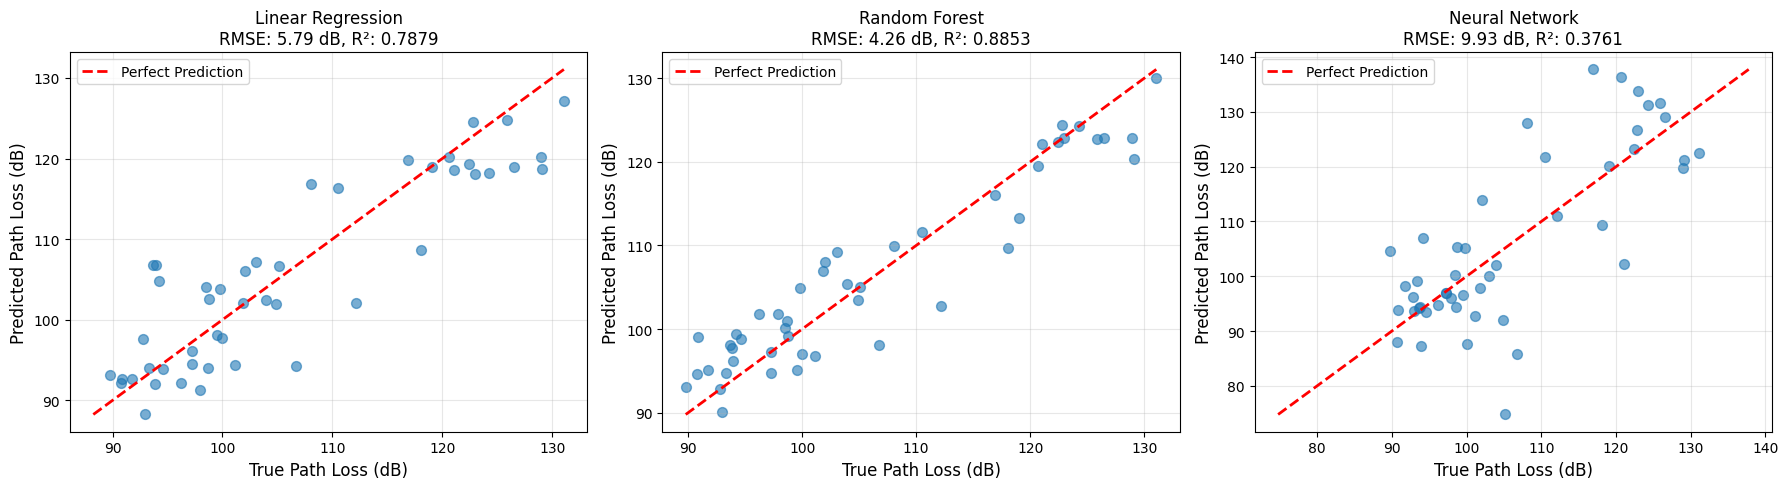

In [ ]:
# Create prediction plots for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_data = [
    ('Linear Regression', y_test_pred_lr, test_rmse_lr, test_r2_lr),
    ('Random Forest', y_test_pred_rf, test_rmse_rf, test_r2_rf),
    ('Neural Network', y_test_pred_nn, test_rmse_nn, test_r2_nn)
]

for idx, (name, y_pred, rmse, r2) in enumerate(models_data):
    ax = axes[idx]

    # Scatter plot
    ax.scatter(y_test, y_pred, alpha=0.6, s=50)

    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    ax.set_xlabel('True Path Loss (dB)', fontsize=12)
    ax.set_ylabel('Predicted Path Loss (dB)', fontsize=12)
    ax.set_title(f'{name}\nRMSE: {rmse:.2f} dB, R²: {r2:.4f}', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

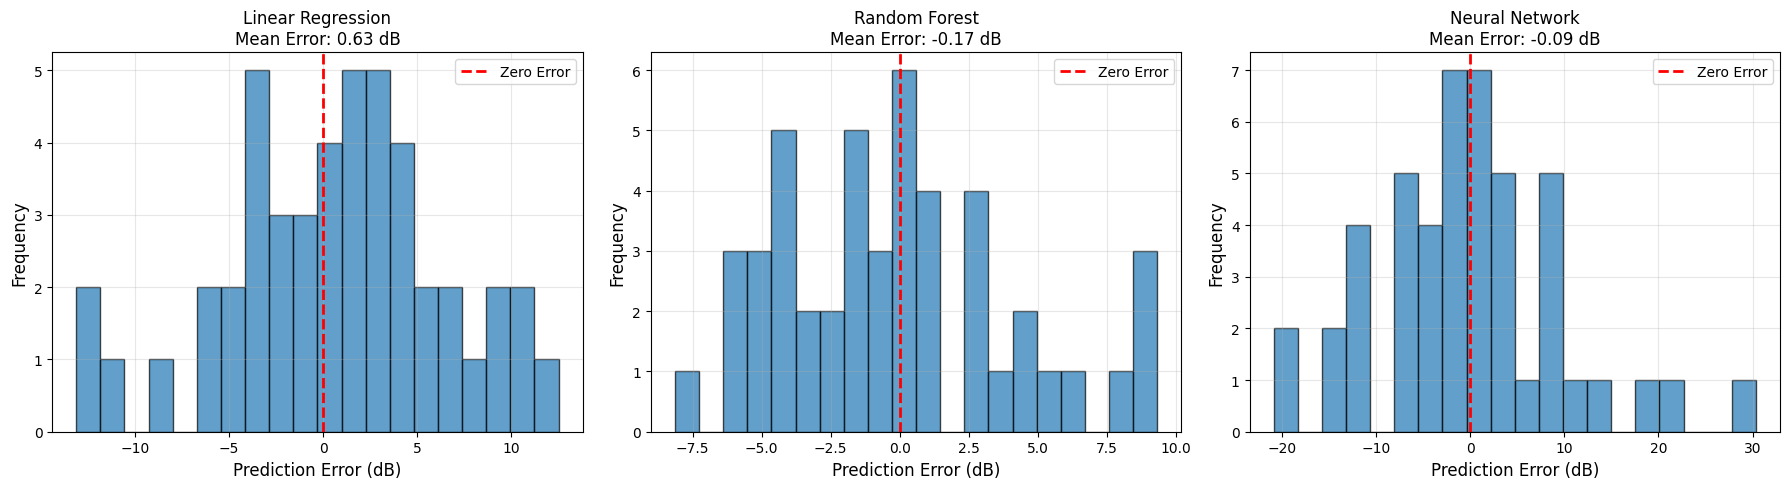

In [ ]:
# Error distribution for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

errors = [
    ('Linear Regression', y_test - y_test_pred_lr),
    ('Random Forest', y_test - y_test_pred_rf),
    ('Neural Network', y_test - y_test_pred_nn)
]

for idx, (name, error) in enumerate(errors):
    ax = axes[idx]

    ax.hist(error, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax.set_xlabel('Prediction Error (dB)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'{name}\nMean Error: {np.mean(error):.2f} dB', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 8: Analyze Feature Importance

We will:
1. Extract feature importance from Random Forest (best model)
2. Analyze regression coefficients from Linear Regression
3. Identify which parameters most strongly influence path loss
4. Interpret results physically

In [ ]:
# Extract feature importance from Random Forest
feature_importance = rf_model.feature_importances_

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("="*60)
print("RANDOM FOREST FEATURE IMPORTANCE")
print("="*60)
print(importance_df.to_string(index=False))

RANDOM FOREST FEATURE IMPORTANCE
      Feature  Importance
    num_paths    0.683862
 mean_theta_r    0.095427
     distance    0.057933
    max_delay    0.040337
         rx_y    0.026553
 mean_theta_t    0.024955
   mean_phi_r    0.023642
   mean_delay    0.020460
   mean_phi_t    0.018261
         rx_x    0.008570
         rx_z    0.000000
     los_flag    0.000000
frequency_ghz    0.000000
tx_array_size    0.000000


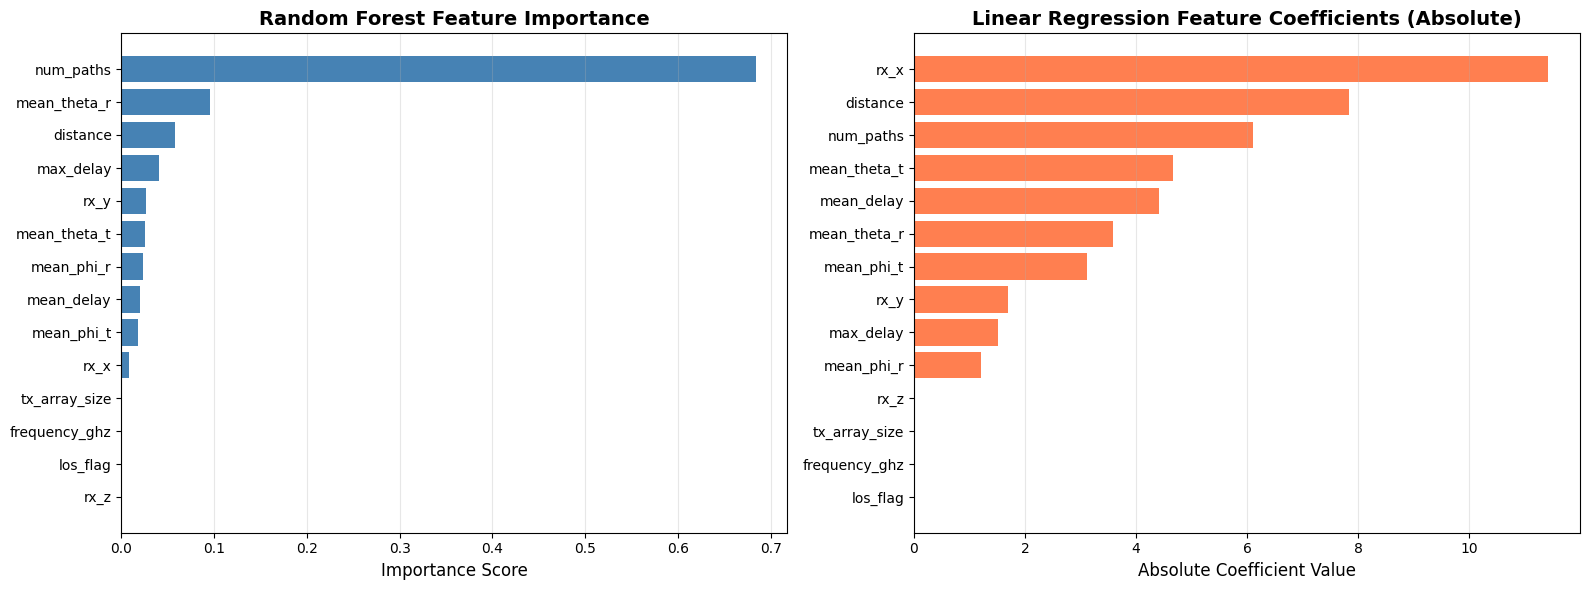

In [ ]:
# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest importance
ax1 = axes[0]
importance_sorted = importance_df.sort_values('Importance', ascending=True)
ax1.barh(importance_sorted['Feature'], importance_sorted['Importance'], color='steelblue')
ax1.set_xlabel('Importance Score', fontsize=12)
ax1.set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Linear Regression coefficients
ax2 = axes[1]
lr_coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': np.abs(lr_model.coef_)
}).sort_values('Coefficient', ascending=True)

ax2.barh(lr_coef_df['Feature'], lr_coef_df['Coefficient'], color='coral')
ax2.set_xlabel('Absolute Coefficient Value', fontsize=12)
ax2.set_title('Linear Regression Feature Coefficients (Absolute)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### Model 2: Random Forest Regression

**Theory:**
- Ensemble of decision trees: f(x) = (1/M) Σ Tₘ(x)
- Each tree splits data based on feature thresholds
- Bootstrapping + feature randomness → reduces overfitting

**Advantages for Wireless:**
- Captures non-linear effects (e.g., shadowing thresholds)
- Handles mixed LoS/NLoS conditions naturally
- Provides feature importance scores

**Reference:** Breiman, L. (2001). "Random Forests." Machine Learning, 45(1), 5-32.

In [ ]:
# Analyze top features based on actual importance values
print("="*70)
print("PHYSICAL INTERPRETATION OF TOP FEATURES")
print("="*70)

top_features = importance_df.head(5)

print("\nTop 5 Most Important Features:\n")
for idx, row in top_features.iterrows():
    feature = row['Feature']
    importance = row['Importance']
    print(f"{idx+1}. {feature}: {importance:.4f}")

print("\n" + "="*70)
print("OBSERVATIONS:")
print("="*70)

# Identify the most important feature
most_important = importance_df.iloc[0]
print(f"\n✓ Most important feature: {most_important['Feature']} ({most_important['Importance']:.4f})")

# Check if distance is in top 3
distance_rank = importance_df[importance_df['Feature'] == 'distance'].index[0] + 1
print(f"✓ Distance ranking: #{distance_rank}")

# Check if LoS is significant
los_importance = importance_df[importance_df['Feature'] == 'los_flag']['Importance'].values[0]
los_rank = importance_df[importance_df['Feature'] == 'los_flag'].index[0] + 1
print(f"✓ LoS flag ranking: #{los_rank} (Importance: {los_importance:.4f})")

# Identify least important features
print(f"\n✓ Least important features:")
for idx, row in importance_df.tail(3).iterrows():
    print(f"  - {row['Feature']}: {row['Importance']:.4f}")

PHYSICAL INTERPRETATION OF TOP FEATURES

Top 5 Most Important Features:

6. num_paths: 0.6839
9. mean_theta_r: 0.0954
4. distance: 0.0579
8. max_delay: 0.0403
2. rx_y: 0.0266

OBSERVATIONS:

✓ Most important feature: num_paths (0.6839)
✓ Distance ranking: #4
✓ LoS flag ranking: #5 (Importance: 0.0000)

✓ Least important features:
  - los_flag: 0.0000
  - frequency_ghz: 0.0000
  - tx_array_size: 0.0000


## Step 9: Reduced-Feature Experiment

We will:
1. Remove features that require ray-tracing knowledge (not observable by RX)
2. Keep only receiver-observable parameters
3. Retrain models with reduced features
4. Compare performance with full-feature models

**Features to REMOVE (require ray-tracing):**
- `num_paths` (requires ray-level knowledge)
- `mean_delay`, `max_delay` (could be estimated but requires processing)
- `mean_theta_t`, `mean_phi_t` (angles of departure - TX side info)

**Features to KEEP (receiver-observable):**
- `rx_x`, `rx_y`, `rx_z` (RX knows its location)
- `distance` (can be estimated from GPS/location)
- `los_flag` (can be estimated from signal characteristics)
- `mean_theta_r`, `mean_phi_r` (angles of arrival - RX can measure)
- `frequency_ghz`, `tx_array_size` (system parameters - known)

In [ ]:
# Define reduced feature set (receiver-observable only)
reduced_feature_cols = ['rx_x', 'rx_y', 'rx_z', 'distance', 'los_flag',
                        'mean_theta_r', 'mean_phi_r',
                        'frequency_ghz', 'tx_array_size']

print("="*70)
print("FEATURE COMPARISON")
print("="*70)
print(f"Full feature set: {len(feature_cols)} features")
print(f"  Features: {feature_cols}")
print(f"\nReduced feature set: {len(reduced_feature_cols)} features")
print(f"  Features: {reduced_feature_cols}")

removed_features = [f for f in feature_cols if f not in reduced_feature_cols]
print(f"\nRemoved features ({len(removed_features)}): {removed_features}")

FEATURE COMPARISON
Full feature set: 14 features
  Features: ['rx_x', 'rx_y', 'rx_z', 'distance', 'los_flag', 'num_paths', 'mean_delay', 'max_delay', 'mean_theta_r', 'mean_phi_r', 'mean_theta_t', 'mean_phi_t', 'frequency_ghz', 'tx_array_size']

Reduced feature set: 9 features
  Features: ['rx_x', 'rx_y', 'rx_z', 'distance', 'los_flag', 'mean_theta_r', 'mean_phi_r', 'frequency_ghz', 'tx_array_size']

Removed features (5): ['num_paths', 'mean_delay', 'max_delay', 'mean_theta_t', 'mean_phi_t']


In [ ]:
# Extract reduced features
X_reduced = df[reduced_feature_cols].values

print(f"Reduced features shape: {X_reduced.shape}")

# Split data
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

# Standardize
scaler_red = StandardScaler()
X_train_red_scaled = scaler_red.fit_transform(X_train_red)
X_test_red_scaled = scaler_red.transform(X_test_red)

print(f"Train set: {X_train_red.shape[0]} samples")
print(f"Test set: {X_test_red.shape[0]} samples")

Reduced features shape: (231, 9)
Train set: 184 samples
Test set: 47 samples


In [ ]:
print("Training models with reduced features...\n")

# 1. Linear Regression
lr_model_red = LinearRegression()
lr_model_red.fit(X_train_red_scaled, y_train_red)
y_test_pred_lr_red = lr_model_red.predict(X_test_red_scaled)
test_rmse_lr_red = np.sqrt(mean_squared_error(y_test_red, y_test_pred_lr_red))
test_r2_lr_red = r2_score(y_test_red, y_test_pred_lr_red)

# 2. Random Forest
rf_model_red = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model_red.fit(X_train_red_scaled, y_train_red)
y_test_pred_rf_red = rf_model_red.predict(X_test_red_scaled)
test_rmse_rf_red = np.sqrt(mean_squared_error(y_test_red, y_test_pred_rf_red))
test_r2_rf_red = r2_score(y_test_red, y_test_pred_rf_red)

# 3. Neural Network
nn_model_red = MLPRegressor(hidden_layer_sizes=(64, 32, 16), activation='relu',
                            max_iter=1000, random_state=42, early_stopping=True)
nn_model_red.fit(X_train_red_scaled, y_train_red)
y_test_pred_nn_red = nn_model_red.predict(X_test_red_scaled)
test_rmse_nn_red = np.sqrt(mean_squared_error(y_test_red, y_test_pred_nn_red))
test_r2_nn_red = r2_score(y_test_red, y_test_pred_nn_red)

print("✓ All models trained with reduced features")

Training models with reduced features...

✓ All models trained with reduced features


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
print("Training models with reduced features...\n")

# 1. Linear Regression
lr_model_red = LinearRegression()
lr_model_red.fit(X_train_red_scaled, y_train_red)
y_test_pred_lr_red = lr_model_red.predict(X_test_red_scaled)
test_rmse_lr_red = np.sqrt(mean_squared_error(y_test_red, y_test_pred_lr_red))
test_r2_lr_red = r2_score(y_test_red, y_test_pred_lr_red)

# 2. Random Forest
rf_model_red = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model_red.fit(X_train_red_scaled, y_train_red)
y_test_pred_rf_red = rf_model_red.predict(X_test_red_scaled)
test_rmse_rf_red = np.sqrt(mean_squared_error(y_test_red, y_test_pred_rf_red))
test_r2_rf_red = r2_score(y_test_red, y_test_pred_rf_red)

# 3. Neural Network
nn_model_red = MLPRegressor(hidden_layer_sizes=(64, 32, 16), activation='relu',
                            max_iter=5000, random_state=42, early_stopping=True)
nn_model_red.fit(X_train_red_scaled, y_train_red)
y_test_pred_nn_red = nn_model_red.predict(X_test_red_scaled)
test_rmse_nn_red = np.sqrt(mean_squared_error(y_test_red, y_test_pred_nn_red))
test_r2_nn_red = r2_score(y_test_red, y_test_pred_nn_red)

print("✓ All models trained with reduced features")

Training models with reduced features...

✓ All models trained with reduced features


In [ ]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Neural Network'],
    'Full Features RMSE': [test_rmse_lr, test_rmse_rf, test_rmse_nn],
    'Full Features R²': [test_r2_lr, test_r2_rf, test_r2_nn],
    'Reduced Features RMSE': [test_rmse_lr_red, test_rmse_rf_red, test_rmse_nn_red],
    'Reduced Features R²': [test_r2_lr_red, test_r2_rf_red, test_r2_nn_red],
    'RMSE Increase': [test_rmse_lr_red - test_rmse_lr,
                      test_rmse_rf_red - test_rmse_rf,
                      test_rmse_nn_red - test_rmse_nn]
})

print("="*90)
print("FULL vs REDUCED FEATURES COMPARISON")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)

# Summary
print("\nKEY FINDINGS:")
for idx, row in comparison_df.iterrows():
    model_name = row['Model']
    rmse_increase = row['RMSE Increase']
    if rmse_increase < 1:
        impact = "minimal"
    elif rmse_increase < 3:
        impact = "moderate"
    else:
        impact = "significant"
    print(f"✓ {model_name}: {impact} impact ({rmse_increase:.2f} dB increase)")

FULL vs REDUCED FEATURES COMPARISON
            Model  Full Features RMSE  Full Features R²  Reduced Features RMSE  Reduced Features R²  RMSE Increase
Linear Regression            5.788452          0.787871               7.348444             0.658126       1.559992
    Random Forest            4.256571          0.885292               4.735121             0.858049       0.478549
   Neural Network            9.927339          0.376063               7.020706             0.687941      -2.906633

KEY FINDINGS:
✓ Linear Regression: moderate impact (1.56 dB increase)
✓ Random Forest: minimal impact (0.48 dB increase)
✓ Neural Network: minimal impact (-2.91 dB increase)


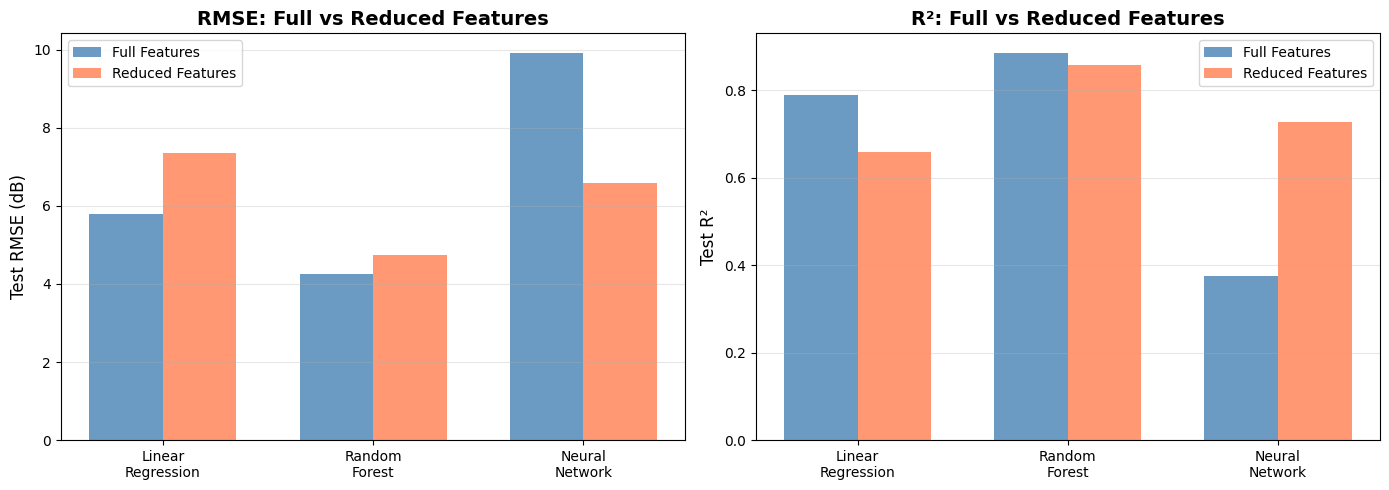

In [ ]:
# Create visualization comparing full vs reduced features
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = ['Linear\nRegression', 'Random\nForest', 'Neural\nNetwork']
x_pos = np.arange(len(models))

# Plot 1: RMSE Comparison
ax1 = axes[0]
width = 0.35
ax1.bar(x_pos - width/2, [test_rmse_lr, test_rmse_rf, test_rmse_nn],
        width, label='Full Features', color='steelblue', alpha=0.8)
ax1.bar(x_pos + width/2, [test_rmse_lr_red, test_rmse_rf_red, test_rmse_nn_red],
        width, label='Reduced Features', color='coral', alpha=0.8)
ax1.set_ylabel('Test RMSE (dB)', fontsize=12)
ax1.set_title('RMSE: Full vs Reduced Features', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: R² Comparison
ax2 = axes[1]
ax2.bar(x_pos - width/2, [test_r2_lr, test_r2_rf, test_r2_nn],
        width, label='Full Features', color='steelblue', alpha=0.8)
ax2.bar(x_pos + width/2, [test_r2_lr_red, test_r2_rf_red, test_r2_nn_red],
        width, label='Reduced Features', color='coral', alpha=0.8)
ax2.set_ylabel('Test R²', fontsize=12)
ax2.set_title('R²: Full vs Reduced Features', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

REDUCED MODEL FEATURE IMPORTANCE (Random Forest)
      Feature  Importance
 mean_theta_r    0.371803
     distance    0.285863
         rx_x    0.139065
   mean_phi_r    0.124278
         rx_y    0.078991
         rx_z    0.000000
     los_flag    0.000000
frequency_ghz    0.000000
tx_array_size    0.000000


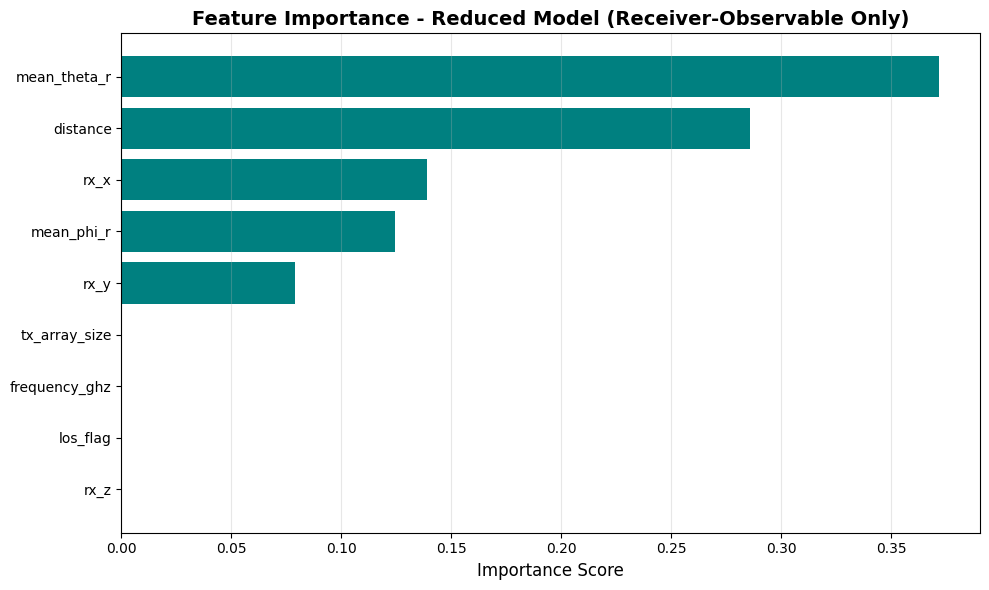

In [ ]:
# Check feature importance for reduced Random Forest model
feature_importance_red = rf_model_red.feature_importances_

importance_df_red = pd.DataFrame({
    'Feature': reduced_feature_cols,
    'Importance': feature_importance_red
}).sort_values('Importance', ascending=False)

print("="*60)
print("REDUCED MODEL FEATURE IMPORTANCE (Random Forest)")
print("="*60)
print(importance_df_red.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
importance_sorted = importance_df_red.sort_values('Importance', ascending=True)
ax.barh(importance_sorted['Feature'], importance_sorted['Importance'], color='teal')
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Feature Importance - Reduced Model (Receiver-Observable Only)',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [ ]:
# Save all results for the report
results_summary = {
    'Scene': 'Simple Street Canyon',
    'Frequency': '28 GHz',
    'TX_Position': tx_position,
    'TX_Array_Size': M,
    'Num_RX_Points': num_rx,
    'Grid_Spacing': f'{grid_spacing} m',
    'LoS_Points': int(np.sum(los_flag)),
    'NLoS_Points': int(num_rx - np.sum(los_flag)),

    # Model Performance - Full Features
    'LR_Full_RMSE': test_rmse_lr,
    'LR_Full_R2': test_r2_lr,
    'RF_Full_RMSE': test_rmse_rf,
    'RF_Full_R2': test_r2_rf,
    'NN_Full_RMSE': test_rmse_nn,
    'NN_Full_R2': test_r2_nn,

    # Model Performance - Reduced Features
    'LR_Red_RMSE': test_rmse_lr_red,
    'LR_Red_R2': test_r2_lr_red,
    'RF_Red_RMSE': test_rmse_rf_red,
    'RF_Red_R2': test_r2_rf_red,
    'NN_Red_RMSE': test_rmse_nn_red,
    'NN_Red_R2': test_r2_nn_red,

    # Path Loss Statistics
    'Mean_Path_Loss': np.mean(path_loss_db),
    'Std_Path_Loss': np.std(path_loss_db),
    'Min_Path_Loss': np.min(path_loss_db),
    'Max_Path_Loss': np.max(path_loss_db)
}

# Print summary
print("="*70)
print("FINAL ASSIGNMENT SUMMARY")
print("="*70)
print(f"\n📍 SCENE CONFIGURATION:")
print(f"  Scene: {results_summary['Scene']}")
print(f"  Frequency: {results_summary['Frequency']}")
print(f"  TX Array: {M}x{M} UPA")
print(f"  Number of RX points: {results_summary['Num_RX_Points']}")
print(f"  LoS/NLoS: {results_summary['LoS_Points']}/{results_summary['NLoS_Points']}")

print(f"\n📊 PATH LOSS STATISTICS:")
print(f"  Mean: {results_summary['Mean_Path_Loss']:.2f} dB")
print(f"  Range: [{results_summary['Min_Path_Loss']:.2f}, {results_summary['Max_Path_Loss']:.2f}] dB")

print(f"\n🤖 BEST MODEL (Full Features): Random Forest")
print(f"  Test RMSE: {results_summary['RF_Full_RMSE']:.2f} dB")
print(f"  Test R²: {results_summary['RF_Full_R2']:.4f}")

print(f"\n🎯 BEST PRACTICAL MODEL (Reduced Features): Random Forest")
print(f"  Test RMSE: {results_summary['RF_Red_RMSE']:.2f} dB")
print(f"  Test R²: {results_summary['RF_Red_R2']:.4f}")
print(f"  Performance loss: {results_summary['RF_Red_RMSE'] - results_summary['RF_Full_RMSE']:.2f} dB")

print(f"\n🔑 TOP 3 FEATURES (Reduced Model):")
for idx, row in importance_df_red.head(3).iterrows():
    print(f"  {idx+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "="*70)

print("="*70)

# Save results to file
import pickle
with open(f'model_results_M{M}.pkl', 'wb') as f:
    pickle.dump({
        'results_summary': results_summary,
        'models': {
            'lr_full': lr_model,
            'rf_full': rf_model,
            'nn_full': nn_model,
            'rf_reduced': rf_model_red
        },
        'scalers': {
            'full': scaler,
            'reduced': scaler_red
        },
        'feature_importance_full': importance_df,
        'feature_importance_reduced': importance_df_red
    }, f)

print(f"\n💾 Results saved to: model_results_M{M}.pkl")

FINAL ASSIGNMENT SUMMARY

📍 SCENE CONFIGURATION:
  Scene: Simple Street Canyon
  Frequency: 28 GHz
  TX Array: 1x1 UPA
  Number of RX points: 231
  LoS/NLoS: 230/1

📊 PATH LOSS STATISTICS:
  Mean: 107.84 dB
  Range: [88.67, 152.18] dB

🤖 BEST MODEL (Full Features): Random Forest
  Test RMSE: 4.26 dB
  Test R²: 0.8853

🎯 BEST PRACTICAL MODEL (Reduced Features): Random Forest
  Test RMSE: 4.74 dB
  Test R²: 0.8580
  Performance loss: 0.48 dB

🔑 TOP 3 FEATURES (Reduced Model):
  6. mean_theta_r: 0.3718
  4. distance: 0.2859
  1. rx_x: 0.1391


💾 Results saved to: model_results_M1.pkl
